✓ CV analysis module imported successfully
✓ Image found: /Users/tk20/Library/Application Support/pibu-ai/case_1765307955905/images/image_0001.png

Running CV Analysis...

📊 METRICS:
  - Compactness Index: 1.605
  - Area (cm²): 0.128
  - Tilt Correction Factor: 1.000
  - Pixels per cm: 205.774

🎨 COLOR STATS (LAB):
  - Mean L: 132.30
  - Mean A: 137.26
  - Mean B: 118.94
  - Std L: 9.14
  - Std A: 1.38
  - Std B: 2.31

🪙 COIN DETECTED:
  - Center: (280, 321)
  - Radius: 196.0 px


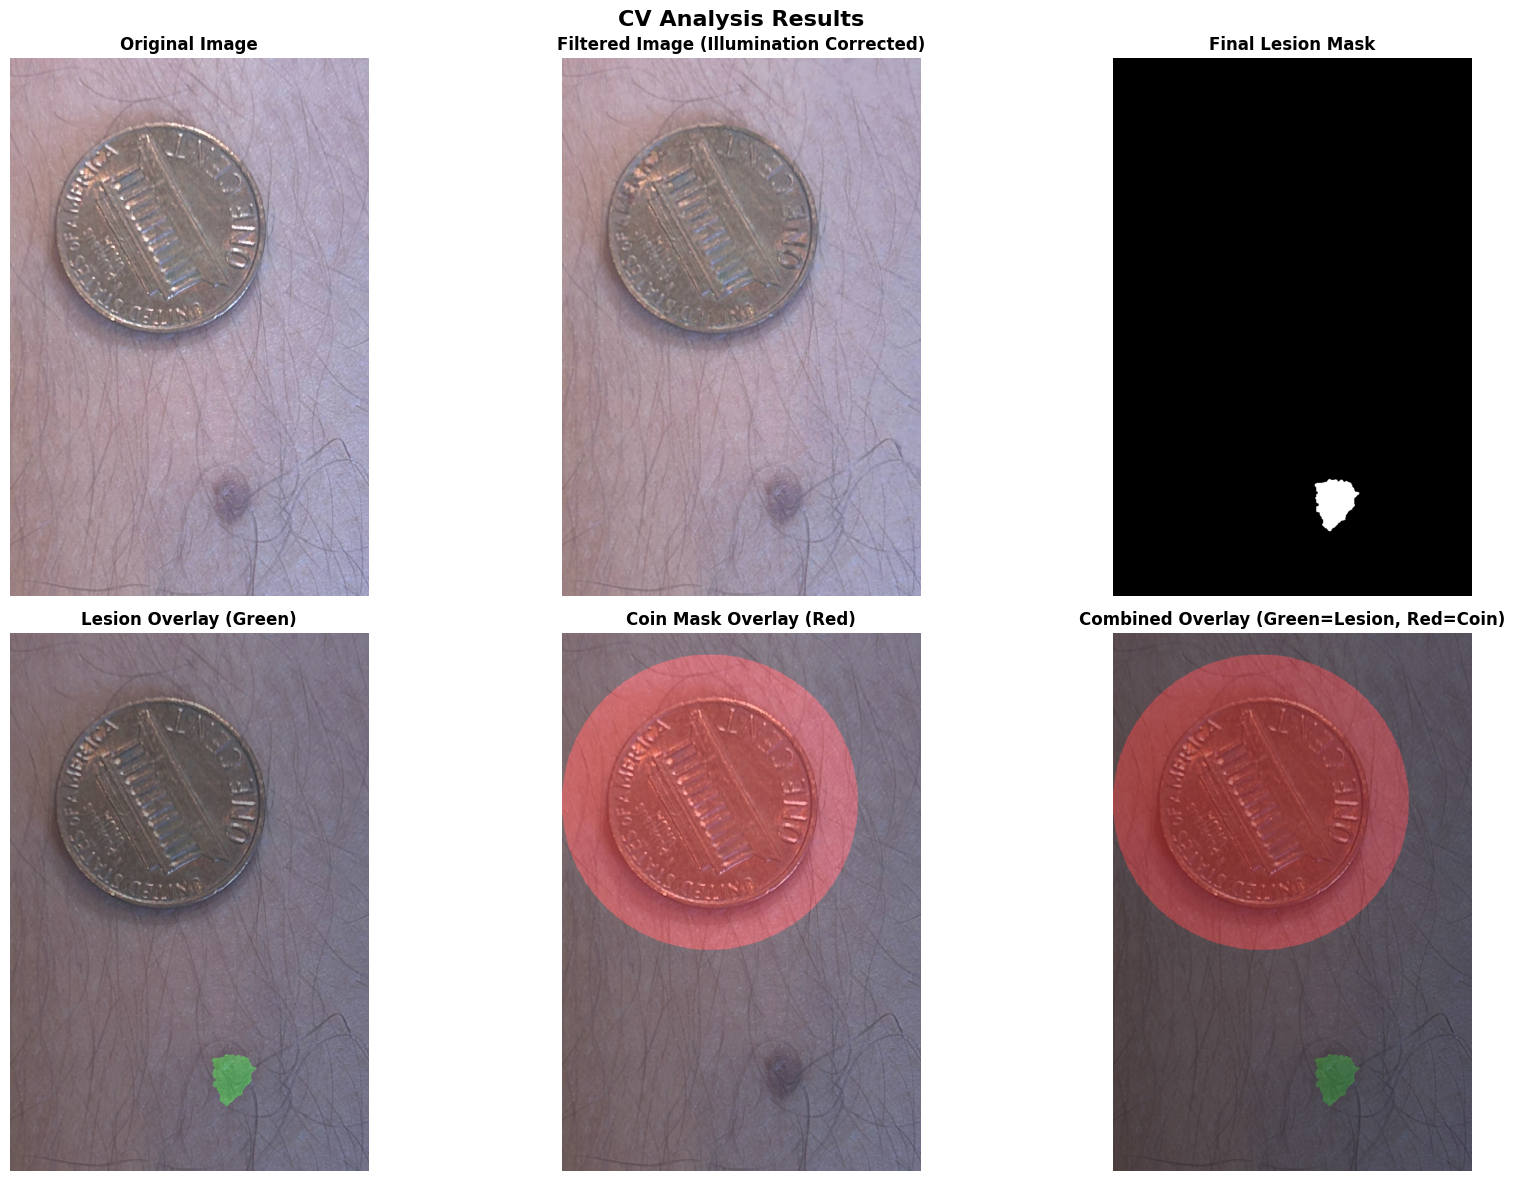


✅ Saved combined overlay to: /Users/tk20/Downloads/cv_analysis_overlay.png


In [ ]:
# CV Module Test with Visualizations
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Add the cv-analysis directory to the path (directory has hyphen, not underscore)
python_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
cv_analysis_dir = python_dir / "cv-analysis"
sys.path.insert(0, str(cv_analysis_dir))

# Import CV analysis module
try:
    from module import run_cv_analysis
    print("✓ CV analysis module imported successfully")
except ImportError as e:
    print(f"✗ Failed to import CV analysis module: {e}")
    print(f"   Python dir: {python_dir}")
    print(f"   CV analysis dir: {cv_analysis_dir}")
    print(f"   CV analysis dir exists: {cv_analysis_dir.exists()}")
    raise

# Set image path (change this to your test image)
image_path = "/Users/tk20/Library/Application Support/pibu-ai/case_1765307955905/images/image_0001.png"  # Update this path
#image_path = "/Users/tk20/Library/Application Support/pibu-ai/case_1765336506136/images/image_0001.png"
# Check if image exists
if not os.path.exists(image_path):
    print(f"⚠️ Image not found at: {image_path}")
    print("Please update the image_path variable with a valid image path")
else:
    print(f"✓ Image found: {image_path}")
    
    # Run CV analysis
    print("\n" + "="*80)
    print("Running CV Analysis...")
    print("="*80)
    
    try:
        result = run_cv_analysis(image_path, bbox=None)
        
        # Extract results
        metrics = result.get("metrics", {})
        masks = result.get("masks", {})
        images = result.get("images", {})
        coin_data = result.get("coin_data")
        
        print("\n📊 METRICS:")
        irregularity = metrics.get('irregularity_index')
        print(f"  - irregularity Index: {irregularity:.3f}" if irregularity is not None else "  - irregularity Index: N/A")
        
        area = metrics.get('area_cm2')
        print(f"  - Area (cm²): {area:.3f}" if area is not None else "  - Area (cm²): N/A")
        
        tilt = metrics.get('tilt_correction_factor')
        print(f"  - Tilt Correction Factor: {tilt:.3f}" if tilt is not None else "  - Tilt Correction Factor: N/A")
        
        pixels_per_cm = result.get('pixels_per_cm')
        print(f"  - Pixels per cm: {pixels_per_cm:.3f}" if pixels_per_cm is not None else "  - Pixels per cm: N/A")
        
        color_stats = metrics.get("color_stats_lab", {})
        if color_stats:
            print(f"\n🎨 COLOR STATS (LAB):")
            print(f"  - Mean L: {color_stats.get('mean_L', 'N/A'):.2f}")
            print(f"  - Mean A: {color_stats.get('mean_A', 'N/A'):.2f}")
            print(f"  - Mean B: {color_stats.get('mean_B', 'N/A'):.2f}")
            print(f"  - Std L: {color_stats.get('std_L', 'N/A'):.2f}")
            print(f"  - Std A: {color_stats.get('std_A', 'N/A'):.2f}")
            print(f"  - Std B: {color_stats.get('std_B', 'N/A'):.2f}")
        
        if coin_data:
            # coin_data is a tuple: (center_x, center_y, radius)
            center_x, center_y, radius = coin_data
            print(f"\n🪙 COIN DETECTED:")
            print(f"  - Center: ({center_x}, {center_y})")
            print(f"  - Radius: {radius:.1f} px")
        else:
            print(f"\n🪙 COIN: Not detected")
        
        # Load original image for visualization
        original_img = cv2.imread(image_path)
        if original_img is None:
            print("⚠️ Could not load original image for visualization")
        else:
            # Convert BGR to RGB for matplotlib
            original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            
            # Resize masks to match original image if needed
            h, w = original_img_rgb.shape[:2]
            
            # Create visualization figure
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle('CV Analysis Results', fontsize=16, fontweight='bold')
            
            # 1. Original Image
            axes[0, 0].imshow(original_img_rgb)
            axes[0, 0].set_title('Original Image', fontweight='bold')
            axes[0, 0].axis('off')
            
            # 2. Filtered Image (illumination corrected)
            if 'filtered_image' in images:
                filtered_img = images['filtered_image']
                if len(filtered_img.shape) == 3:
                    filtered_img_rgb = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB)
                else:
                    filtered_img_rgb = filtered_img
                axes[0, 1].imshow(filtered_img_rgb)
                axes[0, 1].set_title('Filtered Image (Illumination Corrected)', fontweight='bold')
                axes[0, 1].axis('off')
            
            # 3. Final Lesion Mask
            if 'final_mask' in masks:
                final_mask = masks['final_mask']
                if final_mask.shape[:2] != (h, w):
                    final_mask = cv2.resize(final_mask, (w, h), interpolation=cv2.INTER_NEAREST)
                axes[0, 2].imshow(final_mask, cmap='gray')
                axes[0, 2].set_title('Final Lesion Mask', fontweight='bold')
                axes[0, 2].axis('off')
            
            # 4. Lesion Overlay on Original
            if 'final_mask' in masks:
                lesion_mask = masks['final_mask']
                if lesion_mask.shape[:2] != (h, w):
                    lesion_mask = cv2.resize(lesion_mask, (w, h), interpolation=cv2.INTER_NEAREST)
                overlay = original_img_rgb.copy()
                # Create green overlay for lesion
                lesion_overlay = np.zeros_like(overlay)
                lesion_overlay[lesion_mask > 0] = [0, 255, 0]  # Green
                overlay = cv2.addWeighted(overlay, 0.7, lesion_overlay, 0.3, 0)
                axes[1, 0].imshow(overlay)
                axes[1, 0].set_title('Lesion Overlay (Green)', fontweight='bold')
                axes[1, 0].axis('off')
            
            # 5. Coin Mask Overlay
            if 'coin_mask_full' in masks:
                coin_mask = masks['coin_mask_full']
                if coin_mask.shape[:2] != (h, w):
                    coin_mask = cv2.resize(coin_mask, (w, h), interpolation=cv2.INTER_NEAREST)
                coin_overlay = original_img_rgb.copy()
                # Create red overlay for coin
                coin_overlay_mask = np.zeros_like(coin_overlay)
                coin_overlay_mask[coin_mask > 0] = [255, 0, 0]  # Red
                coin_overlay = cv2.addWeighted(coin_overlay, 0.7, coin_overlay_mask, 0.3, 0)
                axes[1, 1].imshow(coin_overlay)
                axes[1, 1].set_title('Coin Mask Overlay (Red)', fontweight='bold')
                axes[1, 1].axis('off')
            else:
                axes[1, 1].text(0.5, 0.5, 'No Coin Detected', 
                               ha='center', va='center', fontsize=14)
                axes[1, 1].axis('off')
            
            # 6. Combined Overlay (Lesion + Coin)
            combined_overlay = original_img_rgb.copy()
            if 'final_mask' in masks:
                lesion_mask = masks['final_mask']
                if lesion_mask.shape[:2] != (h, w):
                    lesion_mask = cv2.resize(lesion_mask, (w, h), interpolation=cv2.INTER_NEAREST)
                lesion_overlay_mask = np.zeros_like(combined_overlay)
                lesion_overlay_mask[lesion_mask > 0] = [0, 255, 0]  # Green
                combined_overlay = cv2.addWeighted(combined_overlay, 0.7, lesion_overlay_mask, 0.3, 0)
            
            if 'coin_mask_full' in masks:
                coin_mask = masks['coin_mask_full']
                if coin_mask.shape[:2] != (h, w):
                    coin_mask = cv2.resize(coin_mask, (w, h), interpolation=cv2.INTER_NEAREST)
                coin_overlay_mask = np.zeros_like(combined_overlay)
                coin_overlay_mask[coin_mask > 0] = [255, 0, 0]  # Red
                combined_overlay = cv2.addWeighted(combined_overlay, 0.7, coin_overlay_mask, 0.3, 0)
            
            axes[1, 2].imshow(combined_overlay)
            axes[1, 2].set_title('Combined Overlay (Green=Lesion, Red=Coin)', fontweight='bold')
            axes[1, 2].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Save overlay image
            try:
                output_path = "/Users/tk20/Downloads/cv_analysis_overlay.png"
                # Convert RGB back to BGR for cv2.imwrite
                combined_overlay_bgr = cv2.cvtColor(combined_overlay, cv2.COLOR_RGB2BGR)
                cv2.imwrite(output_path, combined_overlay_bgr)
                print(f"\n✅ Saved combined overlay to: {output_path}")
            except Exception as e:
                print(f"\n⚠️ Failed to save overlay: {e}")
        
    except Exception as e:
        print(f"\n❌ ERROR during CV analysis: {e}")
        import traceback
        traceback.print_exc()


🧪 TESTING TIME TRACKING API

📤 Request URL: https://tanushkmr2001--dermatology-llm-27b-dermatologyllm-time-t-f8b7ef.modal.run

📋 User Input:
   The age is 75. Sex is male. Race is white. Country is au. The body location of the affected area is upper arm.

📊 CV Analysis History (1 entries):
   - 2025-12-09: area=0.0636 cm², irregularity=1.222


⏳ Calling API...

✅ SUCCESS!
📊 RESPONSE:
{
  "summary": "The spot is now about 0.1 cm\u00b2 and looks a bit more irregular than before. Its color seems slightly lighter."
}


📝 SUMMARY TEXT:
--------------------------------------------------------------------------------
The spot is now about 0.1 cm² and looks a bit more irregular than before. Its color seems slightly lighter.
--------------------------------------------------------------------------------


In [24]:
# Test Time Tracking API Call
import requests
import json
from datetime import datetime

# Time tracking API URL
LLM_TIME_TRACKING_URL = "https://tanushkmr2001--dermatology-llm-27b-dermatologyllm-time-t-f8b7ef.modal.run"

# Dummy case data
dummy_case_data = {
    "dates": {
        "2025-12-09": {
            "cv_analysis": {
                "compactness_index": 1.2216071138431062,
                "color_stats_lab": {
                    "mean_L": 82.51545842217485,
                    "mean_A": 146.74253731343285,
                    "mean_B": 151.8411513859275,
                    "std_L": 14.500249091782916,
                    "std_A": 1.4856537694927738,
                    "std_B": 1.4162217206909766
                },
                "area_cm2": 0.0636305144318031,
                "area_cm2_uncorrected": 0.06176559460734505,
                "tilt_correction_factor": 0.9706914231149772,
                "coin_data": [310, 271, 166]
            },
            "predictions": {
                "benign-nevus": 0.8604901432991028,
                "melanoma": 0.11576559394598007,
                "basal-cell-carcinoma": 0.009352065622806549,
                "seborrheic-keratosis": 0.005018136464059353,
                "hypopigmentation": 0.003345188219100237
            },
            "image_path": "/Users/tk20/Library/Application Support/pibu-ai/case_1765336923519/images/image_0001.png",
            "text_summary": "",
            "tracking_summary": "The spot is now about 0.07 cm² and looks a bit bigger than before. Its color seems slightly less red and less blue."
        },
        "2025-12-10_1765338168632": {
            "image_path": "/var/folders/0k/wz8nbvps6g565rr_vdwxl5w80000gn/T/pibu_uploads/case_1765336923519_timeline_1765338168293_image_0005.png",
            "text_summary": "",
            "cv_analysis": {
                "compactness_index": 1.5909847881004429,
                "color_stats_lab": {
                    "mean_L": 132.13826005612722,
                    "mean_A": 137.2826941066417,
                    "mean_B": 118.95266604303087,
                    "std_L": 9.097978535728702,
                    "std_A": 1.3830356117066145,
                    "std_B": 2.3257224556809466
                },
                "area_cm2": 0.12623085839884424,
                "area_cm2_uncorrected": 0.12623085839884424,
                "tilt_correction_factor": 1.0,
                "coin_data": [280, 321, 196]
            },
            "predictions": {
                "benign-nevus": 0.8604901432991028,
                "melanoma": 0.11576559394598007,
                "basal-cell-carcinoma": 0.009352065622806549,
                "seborrheic-keratosis": 0.005018136464059353,
                "hypopigmentation": 0.003345188219100237
            },
            "tracking_summary": "The spot is about 0.13 cm² and has a fairly regular shape with a light, brownish color. It looks similar in size and appearance compared to the last check."
        }
    },
    "location": {
        "coordinates": [38.94927536231884, 29.526154891304344],
        "nlp": "upper arm"
    },
    "name": "Benign-nevus"
}

# Extract CV analysis history from case data
# Note: The API only uses area_cm2, compactness_index (irregularity), and color_stats_lab
# Entries will be labeled as "Entry 1", "Entry 2", etc. (no dates in labels)
cv_analysis_history = {}
for date, entry in dummy_case_data.get("dates", {}).items():
    if "cv_analysis" in entry:
        cv_analysis_history[date] = entry["cv_analysis"]

# User input (can be modified)
user_input = "The age is 75. Sex is male. Race is white. Country is au. The body location of the affected area is upper arm."

# Build payload
payload = {
    "user_input": user_input,
    "cv_analysis_history": cv_analysis_history
}

print("=" * 80)
print("🧪 TESTING TIME TRACKING API")
print("=" * 80)
print(f"\n📤 Request URL: {LLM_TIME_TRACKING_URL}")
print(f"\n📋 User Input:")
print(f"   {user_input}")
print(f"\n📊 CV Analysis History ({len(cv_analysis_history)} entries):")
print("   Note: API only uses area_cm2, compactness_index (irregularity), and color_stats_lab")
print("   Entries will be labeled as 'Entry 1', 'Entry 2', etc. in the prompt")
for i, (date, cv_data) in enumerate(sorted(cv_analysis_history.items()), 1):
    area = cv_data.get("area_cm2", "N/A")
    compactness = cv_data.get("compactness_index", "N/A")
    color = cv_data.get("color_stats_lab", {})
    mean_L = color.get("mean_L", "N/A")
    mean_A = color.get("mean_A", "N/A")
    mean_B = color.get("mean_B", "N/A")
    print(f"\n   Entry {i} (date: {date}):")
    print(f"     - Area: {area:.4f} cm²" if area != "N/A" else f"     - Area: {area}")
    print(f"     - Irregularity: {compactness:.3f}" if compactness != "N/A" else f"     - Irregularity: {compactness}")
    if mean_L != "N/A":
        print(f"     - Color (LAB): L={mean_L:.1f}, A={mean_A:.1f}, B={mean_B:.1f}")
print("\n" + "=" * 80)

try:
    # Make API call
    print("\n⏳ Calling API...")
    response = requests.post(
        LLM_TIME_TRACKING_URL,
        json=payload,
        timeout=400
    )
    response.raise_for_status()
    result = response.json()
    
    print("\n✅ SUCCESS!")
    print("=" * 80)
    print("📊 RESPONSE:")
    print("=" * 80)
    print(json.dumps(result, indent=2))
    print("\n" + "=" * 80)
    print("\n📝 SUMMARY TEXT:")
    print("-" * 80)
    summary = result.get("summary", "No summary in response")
    print(summary)
    print("-" * 80)
    
except requests.exceptions.RequestException as e:
    print(f"\n❌ ERROR: {type(e).__name__}")
    print(f"   {str(e)}")
    if hasattr(e, 'response') and e.response is not None:
        print(f"\n   Status Code: {e.response.status_code}")
        print(f"   Response: {e.response.text}")
except Exception as e:
    print(f"\n❌ UNEXPECTED ERROR: {type(e).__name__}")
    print(f"   {str(e)}")
    import traceback
    traceback.print_exc()


🧪 TESTING TIME TRACKING API

📤 Request URL: https://tanushkmr2001--dermatology-llm-27b-dermatologyllm-time-t-f8b7ef.modal.run

📋 User Input:
   The age is 75. Sex is male. Race is white. Country is au. The body location of the affected area is upper arm.

📊 CV Analysis History (2 entries):
   Note: API only uses area_cm2, compactness_index (irregularity), and color_stats_lab
   Entries will be labeled as 'Entry 1', 'Entry 2', etc. in the prompt

   Entry 1 (date: 2025-12-09):
     - Area: 0.0636 cm²
     - Irregularity: 1.222
     - Color (LAB): L=82.5, A=146.7, B=151.8

   Entry 2 (date: 2025-12-10_1765338168632):
     - Area: 0.1262 cm²
     - Irregularity: 1.591
     - Color (LAB): L=132.1, A=137.3, B=119.0


⏳ Calling API...

✅ SUCCESS!
📊 RESPONSE:
{
  "summary": "The spot has grown from 0.06 cm\u00b2 to 0.13 cm\u00b2 and become more irregular, going from 1.22 to 1.59. It also appears lighter and less red, with LAB values changing from L=82.5, A=146.7, B=151.8 to L=132.1, A=137.3, 

In [18]:
payload

{'user_input': 'The age is 75. Sex is male. Race is white. Country is au. The body location of the affected area is upper arm.',
 'cv_analysis_history': {'2025-12-09': {'irregularity_index': 1.2216071138431062,
   'color_stats_lab': {'mean_L': 82.51545842217485,
    'mean_A': 146.74253731343285,
    'mean_B': 151.8411513859275,
    'std_L': 14.500249091782916,
    'std_A': 1.4856537694927738,
    'std_B': 1.4162217206909766},
   'area_cm2': 0.0636305144318031,
   'area_cm2_uncorrected': 0.06176559460734505,
   'tilt_correction_factor': 0.9706914231149772,
   'coin_data': [310, 271, 166]}}}

✓ CV analysis module loaded successfully


✓ Imports successful


/Users/tk20/Desktop/APCOMP215/ac215_Group_127_2473879/src/frontend-react/python/test_time_tracking_case
No case history file found for case test_time_tracking_case, using default.
No conversation history file found for case test_time_tracking_case, using default.
No demographics file found for case test_time_tracking_case, using default.


Created APIManager for case: test_time_tracking_case
Dummy mode: False


Demographics: {
  "age": 45,
  "skin_type": "Type III"
}

Top prediction: ('eczema', 0.78)


Calling LLM time tracking summary API...

📤 TIME TRACKING SUMMARY REQUEST:
{
  "predictions": {
    "eczema": 0.78,
    "contact_dermatitis": 0.15,
    "psoriasis": 0.04
  },
  "user_demographics": {
    "age": 45,
    "skin_type": "Type III"
  },
  "user_input": "Red, itchy patch on inner elbow. Gets worse after using scented soap.",
  "cv_analysis_history": {
    "2025-12-07": {
      "compactness_index": 1.3,
      "color_stats_lab": {
        "mean_L": 63.5,
        "mean_A": 22.1,
        "mean_B": 10.8,
        "std_L": 12.5,
        "std_A": 5.8,
        "std_B": 4.2
      },
      "area_cm2": 3.2,
      "tilt_correction_factor": 1.0
    }
  }
}




TEST 1: First Entry (No History)


✅ Time tracking summary received: The affected area on your inner elbow is about 3.2 cm² and shows significant redness. Its shape is s...



📊 TRACKING SUMMARY:
--------------------------------------------------------------------------------
The affected area on your inner elbow is about 3.2 cm² and shows significant redness. Its shape is somewhat irregular, and the texture looks a bit rough. These measurements seem consistent with the suspected eczema, especially given your description of it being red and itchy.
--------------------------------------------------------------------------------


Added first entry to history (2024-11-25)


Calling LLM time tracking summary API...

📤 TIME TRACKING SUMMARY REQUEST:
{
  "predictions": {
    "eczema": 0.78,
    "contact_dermatitis": 0.15,
    "psoriasis": 0.04
  },
  "user_demographics": {
    "age": 45,
    "skin_type": "Type III"
  },
  "user_input": "Applied moisturizer regularly. Redness seems to be fading.",
  "cv_analysis_history": {
    "2024-11-25": {
      "compactness_index": 1.3,
      "color_stats_lab": {
        "mean_L": 63.5,
        "mean_A": 22.1,
        "mean_B": 10.8,
        "std_L": 12.5,
        "std_A": 5.8,
        "std_B": 4.2
      },
      "area_cm2": 3.2,
      "tilt_correction_factor": 1.0
    },
    "2025-12-07": {
      "compactness_index": 1.25,
      "color_stats_lab": {
        "mean_L": 67.2,
        "mean_A": 18.4,
        "mean_B": 9.3,
        "std_L": 11.2,
        "std_A": 4.8,
        "std_B": 3.9
      },
      "area_cm2": 2.1,
      "tilt_correction_factor": 1.0
    }
  }
}




TEST 2: Follow-up Entry (1 Week Later - Improvement)
Area change: 3.2 cm² → 2.1 cm²
Redness change: 22.1 → 18.4


✅ Time tracking summary received: Okay, looking at the tracking data, the affected area has shrunk quite a bit, going from about 3.2 c...



📊 TRACKING SUMMARY:
--------------------------------------------------------------------------------
Okay, looking at the tracking data, the affected area has shrunk quite a bit, going from about 3.2 cm² down to roughly 2.1 cm² over the last month. The redness also seems to be improving, as the color measurements show it's become less intense. These changes are consistent with the suspected eczema and seem to align with your report of applying moisturizer regularly.
--------------------------------------------------------------------------------


Calling LLM time tracking summary API...

📤 TIME TRACKING SUMMARY REQUEST:
{
  "predictions": {
    "eczema": 0.78,
    "contact_dermatitis": 0.15,
    "psoriasis": 0.04
  },
  "user_demographics": {
    "age": 45,
    "skin_type": "Type III"
  },
  "user_input": "Small red patch on forearm",
  "cv_analysis_history": {
    "2025-12-07": {
      "compactness_index": 1.2,
      "color_stats_lab": {
        "mean_L": 65.0,
        "mean_A": 20.0,
        "mean_B": 10.0,
        "std_L": 12.0,
        "std_A": 5.0,
        "std_B": 4.0
      },
      "area_cm2": null,
      "tilt_correction_factor": null
    }
  }
}




TEST 3: No Coin Detected (Relative Measurements Only)


✅ Time tracking summary received: The affected area is a fairly compact patch, measuring about 2.5 cm² with noticeable redness. The sh...



📊 TRACKING SUMMARY:
--------------------------------------------------------------------------------
The affected area is a fairly compact patch, measuring about 2.5 cm² with noticeable redness. The shape is somewhat irregular, and the texture appears slightly raised. These initial measurements seem consistent with the suspected eczema.
--------------------------------------------------------------------------------


🧪 TESTING MODAL TIME TRACKING API ENDPOINT (UPDATED FORMAT)

📤 Request URL: https://tanushkmr2001--dermatology-llm-27b-dermatologyllm-time-t-f8b7ef.modal.run

📋 Request Payload (no predictions or demographics):
{
  "user_input": "Red, itchy patch that has been improving over the past week.",
  "cv_analysis_history": {
    "2024-12-01": {
      "compactness_index": 1.3,
      "color_stats_lab": {
        "mean_L": 63.5,
        "mean_A": 22.1,
        "mean_B": 10.8,
        "std_L": 12.5,
        "std_A": 5.8,
        "std_B": 4.2
      },
      "area_cm2": 3.2,
      "tilt_correction_factor": 1.0
    },
    "2024-12-08": {
      "compactness_index": 1.25,
      "color_stats_lab": {
        "mean_L": 67.2,
        "mean_A": 18.4,
        "mean_B": 9.3,
        "std_L": 11.2,
        "std_A": 4.8,
        "std_B": 3.9
      },
      "area_cm2": 2.1,
      "tilt_correction_factor": 1.0
    }
  }
}


✅ SUCCESS!
📊 RESPONSE:
{
  "summary": "The spot is now about 2.1 cm\u00b2 and looks a bit